# Lecture 10 - Property & Reaction Prediction

```{contents}
:local:
:depth: 1
```

## Learning goals

- Set up **Chemprop v2** for regression and classification on our C-H oxidation dataset.
- Train four **single task** models for: Solubility, pKa, Melting Point, Toxicity.
- Train a **reactivity** classifier and an **atom-level selectivity** predictor.
- Interpret a trained model with **Shapley values (SHAP)** at the feature and node levels.

```{admonition} Important note
For this lecture 10, it is recommended to run everything in Colab. On this HTML page, some outputs are disabled due to execution limits, so only code and some example output is displayed.
```



---

In [1]:
# 1. Setup

# Hide code cell source
import warnings, os, sys
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# RDKit (must be installed in THIS venv)
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem

import warnings, math, os, sys, json, time, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path  
import torch



# Sklearn bits for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)

import logging
logging.getLogger("chemprop.data.splitting").setLevel(logging.ERROR)

# RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
        %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

## 1. Directed message-passing neural network (D-MPNN)

We will train models for four molecular properties and reaction-related labels using **Chemprop**.

Briefly speaking, Chemprop builds neural models for molecules using a *directed* message passing neural network (D-MPNN).

As you recall from previous lecture, a message passing neural network (MPNN) updates hidden vectors on nodes and edges with local neighbor information, then an aggregation step creates a graph-level vector for prediction.

Chemprop’s directed variant changes the way messages flow: instead of passing information back and forth between atoms, it assigns a hidden state to each directed bond (atom `i` → atom `j`). This prevents immediate backtracking (“tottering”) where messages would simply bounce between two atoms without capturing new context. By using directed bonds, the model distinguishes subtle chemical environments. For example, the information carried from a carbon toward a nitrogen can be different than the reverse direction, which matters for reactivity and selectivity.

As a GNN, Chemprop also featurizes a molecule as a **graph**:

- **Nodes** are atoms with features like atomic number, degree, aromaticity.
- **Edges** are bonds with features like bond order and stereo.

Initial directed bond state $h_{i→j}^{(0)}$ is a learned function of the source atom features and the bond features. For `t = 1..T`, update
$
h_{i \to j}^{(t)} = \sigma \Big( W \cdot \big( h_{i \to j}^{(t-1)} + \sum_{k \in \mathcal{N}(i) \setminus \{j\}} h_{k \to i}^{(t-1)} \big) + b \Big)
$,

where `σ` is an activation such as `ReLU`, `W` is a learned weight, $x_{i→j}$ are featurized inputs, $⊕$ is concatenation, and $N(i)\{j}$ removes the target atom to avoid immediate backtracking. After T steps, Chemprop aggregates per directed bond states to atom states, then pools to a molecule vector $h_mol$ using sum or mean or attention pooling. $h_mol$ feeds a multitask feedforward head.

We have been working with the following quite many times:
- **Solubility_mol_per_L**: continuous. Regression with loss like MSE or MAE.
- **pKa**: continuous. Regression.
- **Melting Point**: continuous. Regression.
- **Toxicity**: categorical with values like `toxic` or `non_toxic`. Binary classification.

While these two we never try before:
- **Reactivity**: binary label `1` vs `-1`. Binary classification. In our C-H oxidation dataset, this means whether the substrate will undergo oxidation.
- **Site Selectivity**: a set of atom indices. Atom-level classification inside a molecule. In our C-H oxidation dataset, this means which atom(s) are most likely to oxidize under certain electrochemical reaction condition, expressed as atom indices in the SMILES.

As a reminder, below are some reference formulas:

- Regression losses  
  $$
  \text{MSE} = \frac{1}{n}\sum_i (y_i - \hat y_i)^2,\qquad
  \text{MAE} = \frac{1}{n}\sum_i |y_i - \hat y_i|
  $$
- Binary cross entropy  
  $$
  \mathcal{L} = -\frac{1}{n}\sum_i \big(y_i\log \hat p_i + (1-y_i)\log(1-\hat p_i)\big)
  $$




> You saw this idea in earlier lectures. The new part is that Chemprop builds the graph from SMILES and offers modules for molecule, reaction and atom/bond tasks.

---
## 2. Data preparation

We begin with load and inspect the C-H oxidation dataset.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(5)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2"
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6"


In [3]:
# Basic info
df_raw.shape, df_raw.columns.tolist()

((575, 9),
 ['Compound Name',
  'CAS',
  'SMILES',
  'Solubility_mol_per_L',
  'pKa',
  'Toxicity',
  'Melting Point',
  'Reactivity',
  'Oxidation Site'])

In [4]:
# Clean a copy and normalize a few columns
df = df_raw.copy()

# Toxicity -> binary string 'toxic'/'non_toxic' to 1/0 if present
tox_map = {"toxic": 1, "non_toxic": 0}
if "Toxicity" in df:
    df["tox_bin"] = df["Toxicity"].str.lower().map(tox_map)

# Reactivity -> 1/-1 to 1/0
if "Reactivity" in df:
    df["react_bin"] = df["Reactivity"].map(lambda x: 1 if x==1 else 0)

# Oxidation Site -> list of ints
def parse_sites(x):
    if isinstance(x, str) and len(x.strip())>0:
        return [int(v) for v in x.split(",")]
    return []
df["site_list"] = df["Oxidation Site"].apply(parse_sites)

# Take log of solubility (keep same column name)
if "Solubility_mol_per_L" in df:
    df["logS"] = np.log10(df["Solubility_mol_per_L"] + 1e-6)

df[["SMILES","logS","pKa","Toxicity","Melting Point","react_bin","site_list"]].head(8)

,SMILES,logS,pKa,Toxicity,Melting Point,react_bin,site_list
0,c1ccc2c(c1)CCOC2,-0.983356,5.80,non_toxic,65.8,1,"[8, 10]"
1,c1ccc2c(c1)Cc1ccccc1-2,-1.980414,5.82,toxic,90.0,1,[7]
2,c1ccc2c(c1)CCCC2,-1.686343,5.74,toxic,69.4,1,"[7, 10]"
3,CCc1ccccc1,-1.317782,5.87,non_toxic,65.0,1,"[1, 2]"
4,C1=CCCCC1,-1.216890,5.66,non_toxic,96.4,1,"[3, 6]"
5,C1CCSC1,-0.917634,5.97,non_toxic,15.8,1,"[3, 5]"
6,CN1CCCC1=O,-0.499442,5.91,non_toxic,71.1,1,[3]
7,COCc1ccccc1,-1.070756,5.61,non_toxic,108.5,1,[3]


```{admonition} ⏰ **Exercise 1**
Count number of postive and negative reaction outcomes in `react_bin`.. 
```


We will create **MoleculeDatapoint** objects from SMILES and targets, split the data, and build loaders.
Our first target will be `solubility`.

> Step 1. Build datapoints.

 Each row of the dataframe is now represented as a `MoleculeDatapoint`. It stores the SMILES, the numeric target (solubility here), plus metadata like optional weights.  
 This is the *atomic unit* Chemprop will pass to the featurizer.

```python
# Keep rows that have both SMILES and solubility
df_sol = df[["SMILES","logS"]].dropna()
smis = df_sol["SMILES"].tolist()
ys   = df_sol["logS"].to_numpy().reshape(-1,1)

sol_datapoints = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
len(sol_datapoints), sol_datapoints[0].y.shape
```


Step 2. Split to train, val, test.

  We divided the list of datapoints into three folds.  
   - Training: used to fit model weights.  
   - Validation: used to monitor progress and stop early.  
   - Test: kept blind until the end.  
   Even though we used a random split here, Chemprop also supports scaffold-based splits which are often better for chemistry.


```python
mols = [dp.mol for dp in sol_datapoints]

train_lists, val_lists, test_lists = make_split_indices(
    mols=mols,
    split="random",  # or "scaffold", "stratified", etc.
    sizes=(0.8, 0.1, 0.1),
    seed=0,
    num_replicates=1
)

train_dpss, val_dpss, test_dpss = split_data_by_indices(
    sol_datapoints, train_lists, val_lists, test_lists
)

print(len(train_dpss[0]), len(val_dpss[0]), len(test_dpss[0]))
```

> Step 3. Build dataset objects and scale targets.
A `MoleculeDataset` wraps the datapoints and applies the chosen featurizer.  
   - Here we used `SimpleMoleculeMolGraphFeaturizer`, which turns atoms and bonds into numeric arrays.  
   - We also normalized the target values (subtract mean, divide by std) so the model trains smoothly. The stored `scaler` allows us to unscale predictions back.

```python
feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_set = data.MoleculeDataset(train_dpss[0], featurizer=feat)
scaler = train_set.normalize_targets()  # store mean/var

val_set = data.MoleculeDataset(val_dpss[0], featurizer=feat)
val_set.normalize_targets(scaler)

test_set = data.MoleculeDataset(test_dpss[0], featurizer=feat)

# Peek at one item structure
item0 = train_set[0]
type(item0).__name__, item0.y, item0.mg.V.shape, item0.mg.E.shape
```

> Step 4. Dataloaders.
 Finally, we wrapped datasets in PyTorch-style `DataLoader`s.  
   - Training loader will shuffle each epoch.  
   - Validation and test loaders do not shuffle, to keep evaluation consistent.  
   Batching is automatic: molecules of different sizes are packed together and masks are used internally.
```python
train_loader = data.build_dataloader(train_set, num_workers=0)
val_loader   = data.build_dataloader(val_set, num_workers=0, shuffle=False)
test_loader  = data.build_dataloader(test_set, num_workers=0, shuffle=False)
```

```{admonition} Tip
Scaling targets helps training for many regressors. We keep the unscale transform for outputs inside the model so that you get predictions in the original units.
```
---

## 3. Property prediction (regression)

We will configure a small MPNN for regression.  

In particular, we will:  
1. Choose the neural blocks that define how messages are passed, pooled, and transformed into outputs.  
2. Assemble them into a complete model object.  
3. Set up a training loop with early stopping and checkpoints.  
4. Evaluate predictions on a held-out test set and visualize the quality using a parity plot.  


### 3.1 Pick blocks

```python
mp  = nn.BondMessagePassing()        # node/edge update
agg = nn.MeanAggregation()           # pool node vectors
out = nn.RegressionFFN(              # simple FFN head
    output_transform=nn.UnscaleTransform.from_standard_scaler(scaler)
)
batch_norm = True
metrics = [nn.metrics.RMSE(), nn.metrics.MAE()]  # first metric used for early stopping
```

- **BondMessagePassing()** updates hidden states on each directed bond by passing information across neighbors.  
- **MeanAggregation()** pools hidden vectors to form atom or molecule-level representations. Other options like sum or attention pooling are possible.  
- **RegressionFFN()** is a feed-forward head. Here we attach an `UnscaleTransform` so predictions can be mapped back to the original solubility scale.  
- **Batch normalization** improves stability by normalizing hidden states during training.  
- **Metrics** let us monitor training. RMSE (root mean squared error) and MAE (mean absolute error) are both useful, but RMSE is often more sensitive to large errors and is used for early stopping.


### 3.2 Build model and trainer

Once the blocks are chosen, we wrap them into a full MPNN model. Chemprop uses PyTorch Lightning under the hood, so we also set up a Trainer:

- The ModelCheckpoint callback saves the best version of the model during training, based on validation loss.

- The trainer can run on CPU or GPU (`accelerator="auto"`).

We limit to 15 epochs here for demonstration, but in practice you might extend this depending on dataset size and convergence.

```python
mpnn_sol = models.MPNN(mp, agg, out, batch_norm, metrics)

checkpoint_dir = Path("checkpoints_sol")
checkpoint_dir.mkdir(exist_ok=True)
ckpt = pl.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir), filename="best-{epoch}-{val_loss:.3f}",
    monitor="val_loss", mode="min", save_last=True
)

trainer = pl.Trainer(
    logger=False, enable_checkpointing=True, accelerator="auto",
    devices=1, max_epochs=15, callbacks=[ckpt]
)
mpnn_sol
```
At this stage, we have a complete pipeline: dataset loaders, model blocks, and a trainer that knows when to save progress.
### 3.3 Train

Since we implement everything earlier, now training is as simple as calling `fit()`. The trainer will:

1. Iterate over the training loader each epoch.

2. Evaluate on the validation loader.

3. Save checkpoints when the validation RMSE improves.

During training, you can monitor validation loss to see whether the model is underfitting, overfitting, or converging as expected.

```python
trainer.fit(mpnn_sol, train_loader, val_loader)
```

### 3.4 Test and parity plot

After training, we hold back the test set for final evaluation. We then visualize predicted vs. true values with a parity plot:



```python
results = trainer.test(mpnn_sol, test_loader)

# Gather predictions for parity
import torch
with torch.inference_mode():
    preds = trainer.predict(mpnn_sol, test_loader)
preds = np.concatenate(preds, axis=0).ravel()

y_true = test_set.Y.ravel()
print("Test size:", len(y_true))

plt.scatter(y_true, preds, alpha=0.6)

# Set both axes to the same range
lims = [-3, 1]
plt.plot(lims, lims, "k--")
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True solubility (mol/L)")
plt.ylabel("Predicted")
plt.title("Parity plot: Solubility")
plt.grid(True)
plt.show()
```
```{admonition} Output

│         test/mae          │    0.2726641297340393     │
│         test/rmse         │    0.4700523018836975     │


Test size: 58
```

In [5]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lec-10-pa-plot.png"))

```{admonition} ⏰ Exercise
Change the aggregation from `MeanAggregation()` to `SumAggregation()` and retrain for 10 epochs. Compare RMSE and the parity plot. What changed?
```

---

## 4. Property prediction (classification)


Here we predict `toxic` vs `non_toxic`.

### 4.1 Build classification dataset

```python
df_tox = df[["SMILES","tox_bin"]].dropna()
smis = df_tox["SMILES"].tolist()
ys   = df_tox["tox_bin"].astype(int).to_numpy().reshape(-1,1)

tox_dps = [data.MoleculeDatapoint.from_smi(s,y) for s,y in zip(smis,ys)]
mols = [dp.mol for dp in tox_dps]
tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8,0.1,0.1))
tr, va, te = data.split_data_by_indices(tox_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
tox_tr = data.MoleculeDataset(tr[0], featurizer=feat)
tox_va = data.MoleculeDataset(va[0], featurizer=feat)
tox_te = data.MoleculeDataset(te[0], featurizer=feat)
```

### 4.2 Model and training

```python
mp  = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn = nn.BinaryClassificationFFN(n_tasks=1)
mpnn_tox = models.MPNN(mp, agg, ffn, batch_norm=False)  

tr_loader = data.build_dataloader(tox_tr, num_workers=0)
va_loader = data.build_dataloader(tox_va, num_workers=0, shuffle=False)
te_loader = data.build_dataloader(tox_te, num_workers=0, shuffle=False)

trainer_tox = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs=15)
trainer_tox.fit(mpnn_tox, tr_loader, va_loader)
trainer_tox.test(mpnn_tox, te_loader)
```

```{admonition} Output
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.8480725288391113     │
└───────────────────────────┴───────────────────────────┘
[{'test/roc': 0.8480725288391113}]
```

### 4.3 ROC curve

```python

# Gather probabilities
with torch.inference_mode():
    pred_chunks = trainer_tox.predict(mpnn_tox, te_loader)
proba = np.concatenate(pred_chunks, axis=0).ravel()
y_true = tox_te.Y.ravel().astype(int)

auc = roc_auc_score(y_true, proba)
acc = accuracy_score(y_true, (proba>=0.5).astype(int))
print(f"Test AUC: {auc:.3f}  Accuracy: {acc:.3f}")

fpr, tpr, thr = roc_curve(y_true, proba)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC: Toxicity")
plt.grid(True)
plt.show()
```

In [6]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lec-10-roc.png"))

---

## 5. Reactivity and selectivity

Two targets in this dataset relate to reactions.

- **Reactivity**: binary at the molecule level.
- **Selectivity**: oxidation site indices at the atom level.


Before we train models, let’s **look at the labels**. Let's pick three representative molecules from the C-H oxidation dataset and see their reactivity and selectivity label.

In [7]:
# Helper selection: one negative (no reaction), one positive with a single site, one positive with multiple sites
def pick_representatives(df):
    df_pos = df[(df["react_bin"] == 1) & (df["site_list"].map(len) >= 1)].copy()
    df_pos_multi = df_pos[df_pos["site_list"].map(len) >= 2].copy()
    df_neg = df[(df["react_bin"] == 0)].copy()

    reps = []
    if not df_neg.empty:
        reps.append(("Negative (react_bin=0)", df_neg.iloc[0]))
    if not df_pos.empty:
        reps.append(("Positive (react_bin=1; 1 site)", df_pos[df_pos["site_list"].map(len) == 1].iloc[0]
                     if (df_pos["site_list"].map(len) == 1).any() else df_pos.iloc[0]))
    if not df_pos_multi.empty:
        reps.append(("Positive (react_bin=1; multi-site)", df_pos_multi.iloc[0]))

    # If fewer than 3 examples exist, just return what we have
    return reps

reps = pick_representatives(df)
len(reps), [t for t,_ in reps]
# Show the chosen rows so readers see SMILES and labels
import pandas as pd

def row_view(r):
    return {
        "SMILES": r["SMILES"],
        "react_bin": r["react_bin"],
        "site_list (1-based)": r["site_list"]
    }

rep_table = pd.DataFrame([row_view(row) for _, row in reps])
rep_table

,SMILES,react_bin,site_list (1-based)
0,Nc1c(Oc2ccccc2)cc(O)c2c1C(=O)c1ccccc1C2=O,0,[-1]
1,c1ccc2c(c1)Cc1ccccc1-2,1,[7]
2,c1ccc2c(c1)CCOC2,1,"[8, 10]"


Let's draw them:

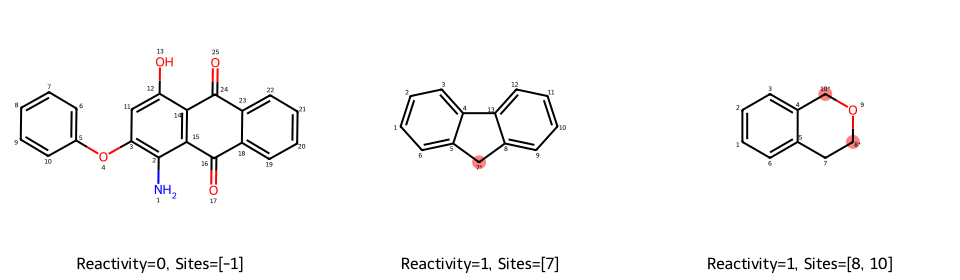

In [8]:
from rdkit.Chem.Draw import rdMolDraw2D

def make_annotated_copy(mol, site_list_1based=None, tag_c123=True):
    m = Chem.Mol(mol)  # copy
    Chem.AssignAtomChiralTagsFromStructure(m)
    Chem.Kekulize(m, clearAromaticFlags=True)
    n = m.GetNumAtoms()
    # Highlight oxidation sites (convert to 0-based safely)
    hi_atoms = []
    if site_list_1based:
        for idx1 in site_list_1based:
            j = idx1 - 1
            if 0 <= j < n:
                hi_atoms.append(j)

    # Always annotate the atom index so readers see 1-based indexing used in labels
    for j in range(n):
        a = m.GetAtomWithIdx(j)
        idx1 = j + 1
        old = a.GetProp("atomNote") if a.HasProp("atomNote") else ""
        # If this atom is an oxidation site, add a star
        star = "*" if (j in hi_atoms) else ""
        a.SetProp("atomNote", f"{old} {idx1}{star}".strip())

    return m, hi_atoms

def draw_examples(reps, mol_size=(320, 280)):
    ms = []
    legends = []
    highlights = []

    for title, row in reps:
        smi = row["SMILES"]
        m = Chem.MolFromSmiles(smi)
        if m is None:
            continue
        m_annot, hi = make_annotated_copy(m, site_list_1based=row["site_list"], tag_c123=True)
        ms.append(m_annot)
        lbl = f"Reactivity={row['react_bin']}, Sites={row['site_list']}"
        legends.append(lbl)
        highlights.append(hi)

    imgs = []
    for m, hi, lg in zip(ms, highlights, legends):
        img = Draw.MolToImage(m, size=mol_size, highlightAtoms=hi)
        img.info["legend"] = lg
        imgs.append(img)

    # Create a grid image manually by re-drawing with legends
    return Draw.MolsToGridImage(ms, molsPerRow=len(ms), subImgSize=mol_size,
                                legends=legends,
                                highlightAtomLists=highlights)

grid_img = draw_examples(reps)
grid_img

### 5.1 Reactivity classifier

This mirrors the toxicity workflow.

```python
df_rxn = df[["SMILES","react_bin"]].dropna()
smis = df_rxn["SMILES"].tolist()
ys   = df_rxn["react_bin"].astype(int).to_numpy().reshape(-1,1)

rxn_dps = [data.MoleculeDatapoint.from_smi(s,y) for s,y in zip(smis, ys)]
mols = [dp.mol for dp in rxn_dps]
tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8,0.1,0.1))
tr, va, te = data.split_data_by_indices(rxn_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
rxn_tr = data.MoleculeDataset(tr[0], featurizer=feat)
rxn_va = data.MoleculeDataset(va[0], featurizer=feat)
rxn_te = data.MoleculeDataset(te[0], featurizer=feat)

mp  = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn = nn.BinaryClassificationFFN(n_tasks=1)
mpnn_rxn = models.MPNN(mp, agg, ffn, batch_norm=False)

tr_loader = data.build_dataloader(rxn_tr, num_workers=0)
va_loader = data.build_dataloader(rxn_va, num_workers=0, shuffle=False)
te_loader = data.build_dataloader(rxn_te, num_workers=0, shuffle=False)

trainer_rxn = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs=15)
trainer_rxn.fit(mpnn_rxn, tr_loader, va_loader)
trainer_rxn.test(mpnn_rxn, te_loader)
```

```{admonition} Output
[{'test/roc': 0.9569892883300781}]
```

### 5.2 Atom-level selectivity: build labels per atom

We want atom targets `1` for indices that appear in `site_list`, and `0` otherwise.

We will create **MolAtomBondDatapoint** objects. For a gentle first pass, we only supply `atom_y` and leave other advanced inputs out.

```python

def atoms_labels_from_smiles(smi, positive_idxs):
    if Chem is None:
        return None
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return None
    n = m.GetNumAtoms()
    y = np.zeros((n,1), dtype=float)
    for idx in positive_idxs:
        # dataset uses 1-based indexing in the text, RDKit uses 0-based
        j = idx-1
        if 0 <= j < n:
            y[j,0] = 1.0
    return y

# Build list of MolAtomBondDatapoint for selectivity
sel_rows = df[["SMILES","site_list"]].dropna()
sel_dps = []
for smi, sites in sel_rows.itertuples(index=False):
    atom_y = atoms_labels_from_smiles(smi, sites)
    if atom_y is None:
        continue
    # We provide atom_y, molecule-level y is optional here
    dp = data.MolAtomBondDatapoint.from_smi(
        smi, atom_y=atom_y, reorder_atoms=False
    )
    sel_dps.append(dp)

len(sel_dps), type(sel_dps[0]).__name__
```

Split and dataset construction.

```python
mols = [Chem.MolFromSmiles(dp.name) if hasattr(dp, "name") else None for dp in sel_dps]
# For structure-based split we need RDKit Mol. Build directly from SMILES fallback:
mols = [Chem.MolFromSmiles(df.loc[df["SMILES"]==dp.name, "SMILES"].iloc[0]) if Chem else None for dp in sel_dps]

tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
tr, va, te = data.split_data_by_indices(sel_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
tr_set = data.MolAtomBondDataset(tr[0], featurizer=feat)
va_set = data.MolAtomBondDataset(va[0], featurizer=feat)
te_set = data.MolAtomBondDataset(te[0], featurizer=feat)

tr_loader = data.build_dataloader(tr_set, shuffle=True, batch_size=8)
va_loader = data.build_dataloader(va_set, shuffle=False, batch_size=8)
te_loader = data.build_dataloader(te_set, shuffle=False, batch_size=8)
```

Model for molecule and atom predictions. Here we focus on atom prediction.

```python
mp = nn.MABBondMessagePassing(
    d_v=feat.atom_fdim, d_e=feat.bond_fdim, d_h=300, depth=3, dropout=0.1
)
agg = nn.MeanAggregation()

atom_predictor = nn.BinaryClassificationFFN(n_tasks=1)  # atom-level 0/1

model_sel = models.MolAtomBondMPNN(
    message_passing=mp,
    agg=agg,
    mol_predictor=None,
    atom_predictor=atom_predictor,
    bond_predictor=None,
    batch_norm=True,
    metrics=[nn.metrics.BinaryAUROC()],
)

trainer_sel = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs=8)
trainer_sel.fit(model_sel, tr_loader, va_loader)
trainer_sel.test(model_sel, te_loader)
```

```{admonition} Output
[{'atom_test/roc': 0.8910984396934509}]
```

Inspect a molecule with predicted atom probabilities by Visualizing probabilities as atom annotations for the first molecule in the batch.

```PYTHON
:tags: [hide-input]
# 1) Pick which test item to visualize
idx = 11  # change as you like

# 2) Grab the original datapoint (not the already-featurized datum)
dp = te_set.data[idx]   # IMPORTANT: .data gives you the raw MolAtomBondDatapoint

# 3) Make a one-item MolAtomBondDataset with the SAME featurizer you used before
single_ds = data.MolAtomBondDataset([dp], featurizer=feat)

# 4) Build a loader and get its batch
single_loader = data.build_dataloader(single_ds, shuffle=False, batch_size=1)
batch = next(iter(single_loader))  # this now matches collate expectations

with torch.inference_mode():
    out = model_sel(batch[0], None)   # batch[0] is the MolGraphBatch

# 6) Unpack outputs and get per-atom probabilities
_, atom_logits, _ = out
atom_probs = torch.sigmoid(atom_logits).cpu().numpy().ravel()

print("Atom count:", len(atom_probs))
print("First 10 probabilities:", atom_probs[:10])

# 7) Draw the SAME molecule with aligned probabilities
smi = dp.name  # MolAtomBondDatapoint stores SMILES in .name
m = Chem.MolFromSmiles(smi)
m2 = Chem.Mol(m)
for i, a in enumerate(m2.GetAtoms()):
    a.SetProp("atomNote", f"{atom_probs[i]:.2f}")
img = Draw.MolToImage(m2, size=(400, 400))
display(img)

```






```{admonition} ⏰ Exercise 7.1
Switch the atom predictor to a small regression head and train with labels 0.0 or 1.0. Then threshold the outputs at 0.5 to recover classes. Compare AUROC.
```



---

## 6. Rationale

In this section we ask **why** the model makes its predictions. Instead of just reporting a number for solubility or reactivity, we try to find the *substructures* of a molecule that drive the prediction.

The method we use is a simplified form of **Monte Carlo Tree Search (MCTS) rationale extraction** from the Chemprop:

1. **Start with the whole molecule** and its predicted property.
2. **Systematically remove small fragments** (like a bond or a ring) and check how the model’s prediction changes for the remaining subgraph.
3. Build a search tree of candidate subgraphs and keep the ones that still predict strongly for the property of interest.
4. From this set, report the **smallest and most predictive subgraph** as the *rationale*.

```python

# Predict a list of SMILES with a single-task model. Returns array shape (n, 1).
def make_prediction(models_in: List[MPNN], trainer_in: pl.Trainer, smiles: List[str]) -> np.ndarray:
    test_data = [data.MoleculeDatapoint.from_smi(s) for s in smiles]
    test_dset = data.MoleculeDataset(test_data)
    test_loader = data.build_dataloader(test_dset, batch_size=1, num_workers=0, shuffle=False)
    with torch.inference_mode():
        agg = None
        for m in models_in:
            pred_batches = trainer_in.predict(m, test_loader)  # list of tensors/arrays
            preds = torch.cat([torch.as_tensor(pb) for pb in pred_batches], dim=0).cpu().numpy()
            agg = preds if agg is None else (agg + preds)
    return agg / len(models_in)

# ---- MCTS components (as in tutorial, with safer kekulize handling) ----
@dataclass
class MCTSNode:
    smiles: str
    atoms: Iterable[int]
    W: float = 0
    N: float = 0
    P: float = 0
    children: list = field(default_factory=list)
    def __post_init__(self): self.atoms = set(self.atoms)
    def Q(self) -> float: return self.W / self.N if self.N > 0 else 0
    def U(self, n: int, c_puct: float = 10.0) -> float: return c_puct * self.P * math.sqrt(n) / (1 + self.N)

def find_clusters(mol: Chem.Mol) -> Tuple[List[Tuple[int,...]], List[List[int]]]:
    n = mol.GetNumAtoms()
    if n == 1: return [(0,)], [[0]]
    clusters = []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if not b.IsInRing():
            clusters.append((i, j))
    ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(ssr)
    atom_cls = [[] for _ in range(n)]
    for k, cl in enumerate(clusters):
        for a in cl: atom_cls[a].append(k)
    return clusters, atom_cls

def extract_subgraph_from_mol(mol: Chem.Mol, selected_atoms: set) -> Tuple[Chem.Mol, List[int]]:
    sel = set(selected_atoms)
    roots = []
    for idx in sel:
        atom = mol.GetAtomWithIdx(idx)
        if any(nei.GetIdx() not in sel for nei in atom.GetNeighbors()):
            roots.append(idx)
    rw = Chem.RWMol(mol)
    for idx in roots:
        a = rw.GetAtomWithIdx(idx)
        a.SetAtomMapNum(1)
        aroma = [b for b in a.GetBonds() if b.GetBondType() == Chem.rdchem.BondType.AROMATIC]
        aroma = [b for b in aroma if b.GetBeginAtom().GetIdx() in sel and b.GetEndAtom().GetIdx() in sel]
        if len(aroma) == 0: a.SetIsAromatic(False)
    for idx in sorted([a.GetIdx() for a in rw.GetAtoms() if a.GetIdx() not in sel], reverse=True):
        rw.RemoveAtom(idx)
    return rw.GetMol(), roots

def extract_subgraph(smiles: str, selected_atoms: set) -> Tuple[Union[str,None], Union[List[int],None]]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None, None
    # try kekulized
    try:
        mk = Chem.Mol(mol); Chem.Kekulize(mk)
        sub, roots = extract_subgraph_from_mol(mk, selected_atoms)
        try:
            smi = Chem.MolToSmiles(sub, kekuleSmiles=True)
            sub = Chem.MolFromSmiles(smi)
        except Exception: sub = None
        if sub is not None and mol.HasSubstructMatch(sub): return Chem.MolToSmiles(sub), roots
    except Exception:
        pass
    # fallback without kekulize
    sub, roots = extract_subgraph_from_mol(mol, selected_atoms)
    try:
        smi = Chem.MolToSmiles(sub)
        sub = Chem.MolFromSmiles(smi)
    except Exception: sub = None
    return (Chem.MolToSmiles(sub), roots) if sub is not None else (None, None)

def mcts_rollout(node: MCTSNode, state_map, orig_smiles, clusters, atom_cls, nei_cls,
                 scoring_fn: Callable[[List[str]], np.ndarray], min_atoms=8, c_puct=10.0) -> float:
    cur = node.atoms
    if len(cur) <= min_atoms: return node.P
    if len(node.children) == 0:
        cur_cls = set([i for i, x in enumerate(clusters) if x <= cur])
        for i in cur_cls:
            leaf_atoms = [a for a in clusters[i] if len(atom_cls[a] & cur_cls) == 1]
            if len(nei_cls[i] & cur_cls) == 1 or (len(clusters[i]) == 2 and len(leaf_atoms) == 1):
                new_atoms = cur - set(leaf_atoms)
                new_smi, _ = extract_subgraph(orig_smiles, new_atoms)
                if not new_smi: continue
                node.children.append(state_map.get(new_smi, MCTSNode(new_smi, new_atoms)))
        state_map[node.smiles] = node
        if len(node.children) == 0: return node.P
        scores = scoring_fn([x.smiles for x in node.children])
        for child, sc in zip(node.children, scores): child.P = float(sc)
    totalN = sum(c.N for c in node.children)
    nxt = max(node.children, key=lambda x: x.Q() + x.U(totalN, c_puct=c_puct))
    v = mcts_rollout(nxt, state_map, orig_smiles, clusters, atom_cls, nei_cls, scoring_fn, min_atoms=min_atoms, c_puct=c_puct)
    nxt.W += v; nxt.N += 1
    return v

def run_mcts_for_smiles(smi: str, scoring_fn, rollout=10, c_puct=10.0,
                        min_atoms=8, max_atoms=20) -> List[MCTSNode]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None: return []
    clusters_raw, atom_cls_raw = find_clusters(mol)
    clusters = [set(cl) for cl in clusters_raw]
    atom_cls = [set(x) for x in atom_cls_raw]
    nei_cls = []
    for i, cl in enumerate(clusters):
        neigh = [nei for a in cl for nei in atom_cls_raw[a]]
        nei_cls.append(set(neigh) - {i})
    root = MCTSNode(smi, set(range(mol.GetNumAtoms())))
    state_map = {smi: root}
    for _ in range(rollout):
        mcts_rollout(root, state_map, smi, clusters, atom_cls, nei_cls, scoring_fn, min_atoms=min_atoms, c_puct=c_puct)
    rats = [node for _, node in state_map.items() if node.smiles is not None and len(node.atoms) <= max_atoms]
    return rats

# Simple fragment fallback if MCTS cannot find anything
def find_fragments(mol: Chem.Mol):
    frags = []
    for b in mol.GetBonds():
        if not b.IsInRing():
            frags.append({b.GetBeginAtomIdx(), b.GetEndAtomIdx()})
    try:
        for ring in Chem.GetSymmSSSR(mol):
            frags.append(set(int(i) for i in ring))
    except Exception:
        pass
    return frags

def fragment_top1(smi: str, scoring_fn) -> List[Tuple[str, float]]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None: return []
    cands = []
    for aset in find_fragments(mol):
        sub_smi, _ = extract_subgraph(smi, aset)
        if sub_smi: cands.append(sub_smi)
    if not cands: return []
    cands = list(dict.fromkeys(cands))
    scores = scoring_fn(cands)
    idx = int(np.argmax(scores))
    return [(cands[idx], float(scores[idx]))]

def visualize_rationale_on_parent(parent_smi: str, rationale_smi: str, size=(520, 420)):
    pm = Chem.MolFromSmiles(parent_smi)
    rm = Chem.MolFromSmiles(rationale_smi)
    if pm is None or rm is None:
        print("Cannot draw: invalid SMILES.")
        return
    match = pm.GetSubstructMatch(rm)
    hi_atoms = list(match) if match else []
    drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    opts = drawer.drawOptions()
    for attr in ("atomLabelFontSize", "fontSize", "scalingFactor"):
        if hasattr(opts, attr):
            try:
                setattr(opts, attr, 0.9)
                break
            except Exception:
                pass
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, pm,
                                       highlightAtoms=hi_atoms if hi_atoms else None)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    display(Image(data=png))

```



Because scoring is done by predicting each subgraph as if it were a standalone molecule, the absolute values (like negative `logS`) may not be directly comparable to the parent’s score. What matters is the **difference (Δ)**: how much the rationale’s score differs from the parent. A positive Δ means the subgraph supports the property; a negative Δ means removing that part lowers the property.

We generate a **summary table** with one rationale (`rationale_0`) for each molecule:

- `smiles`: the original molecule  
- `logS` or `react_prob`: the model’s prediction on the full molecule  
- `rationale_0`: the SMILES string of the key substructure  
- `rationale_0_score`: the model’s prediction on that substructure  
- `rationale_0_delta`: the difference between rationale and parent  

Finally, we **visualize the rationale** by highlighting the matching atoms in the parent molecule. This lets us

### 6.1 Solubility prediction rationale

```python
# ===== Solubility summary table with top-1 rationale =====
# Uses your trained mpnn_sol and trainer, and df_sol["SMILES"]

models_sol = [mpnn_sol]  # must be single-task regression
prop_name = "logS"

def scoring_fn_sol(smiles_list: List[str]) -> np.ndarray:
    return make_prediction(models_sol, trainer, smiles_list)[:, 0]

# Build table
N = 15  # how many molecules to summarize
sample_smis = df_sol["SMILES"].tolist()[:N]

rows = {"smiles": [], prop_name: [], "rationale_0": [], "rationale_0_score": []}

t0 = time.time()
for smi in sample_smis:
    base = float(scoring_fn_sol([smi])[0])
    rows["smiles"].append(smi)
    rows[prop_name].append(base)

    # size-aware MCTS settings
    mol = Chem.MolFromSmiles(smi)
    n = mol.GetNumAtoms() if mol is not None else 20
    min_atoms = max(3, int(0.30 * n))
    max_atoms = max(min_atoms + 1, int(0.60 * n))

    rats = run_mcts_for_smiles(smi, scoring_fn_sol, rollout=10, c_puct=10.0,
                               min_atoms=min_atoms, max_atoms=max_atoms)

    if rats:
        # choose smallest subgraphs, then highest score
        ms = min(len(x.atoms) for x in rats)
        kept = [x for x in rats if len(x.atoms) == ms and x.smiles is not None]
        kept.sort(key=lambda x: x.P, reverse=True)
        r0 = kept[0].smiles
        r0s = float(kept[0].P)
    else:
        # fallback to fragment top1
        top1 = fragment_top1(smi, scoring_fn_sol)
        if top1:
            r0, r0s = top1[0]
        else:
            r0, r0s = None, None

    rows["rationale_0"].append(r0)
    rows["rationale_0_score"].append(r0s)

elapsed = time.time() - t0
print(f"Solubility: built table for {len(sample_smis)} molecules in {elapsed:.2f}s")



solubility_rationales = pd.DataFrame(rows)
solubility_rationales

if pd.notna(solubility_rationales.loc[0, "rationale_0"]):
    parent = solubility_rationales.loc[0, "smiles"]
    rat    = solubility_rationales.loc[0, "rationale_0"]
    print("Parent:", parent)
    print("Rationale 0:", rat, " score=", solubility_rationales.loc[0, "rationale_0_score"])
    visualize_rationale_on_parent(parent, rat)

```
### 6.2 Reactivity prediction rationale

```python
# ===== Reactivity summary table with top-1 rationale =====
# Uses your trained mpnn_rxn and trainer_rxn, and df_rxn["SMILES"]

models_rxn = [mpnn_rxn]     # single-task binary classification head
trainer_cls = trainer_rxn   # your classification trainer

def scoring_fn_rxn(smiles_list: List[str]) -> np.ndarray:
    # predict logits, convert to probabilities with sigmoid
    preds = make_prediction(models_rxn, trainer_cls, smiles_list)[:, 0]
    # Some builds return probs already; to be safe, apply sigmoid if outside [0,1]
    if ((preds < 0) | (preds > 1)).any():
        preds = 1.0 / (1.0 + np.exp(-preds))
    return preds.reshape(-1,)

# Build table
N = 15
sample_smis_rxn = df_rxn["SMILES"].tolist()[:N]

rows_rxn = {"smiles": [], "react_prob": [], "rationale_0": [], "rationale_0_score": []}

t0 = time.time()
for smi in sample_smis_rxn:
    base_p = float(scoring_fn_rxn([smi])[0])
    rows_rxn["smiles"].append(smi)
    rows_rxn["react_prob"].append(base_p)

    mol = Chem.MolFromSmiles(smi)
    n = mol.GetNumAtoms() if mol is not None else 20
    min_atoms = max(3, int(0.30 * n))
    max_atoms = max(min_atoms + 1, int(0.60 * n))

    rats = run_mcts_for_smiles(smi, scoring_fn_rxn, rollout=10, c_puct=10.0,
                               min_atoms=min_atoms, max_atoms=max_atoms)

    if rats:
        ms = min(len(x.atoms) for x in rats)
        kept = [x for x in rats if len(x.atoms) == ms and x.smiles is not None]
        kept.sort(key=lambda x: x.P, reverse=True)
        r0 = kept[0].smiles
        r0s = float(kept[0].P)
    else:
        top1 = fragment_top1(smi, scoring_fn_rxn)
        if top1:
            r0, r0s = top1[0]
        else:
            r0, r0s = None, None

    rows_rxn["rationale_0"].append(r0)
    rows_rxn["rationale_0_score"].append(r0s)

elapsed = time.time() - t0
print(f"Reactivity: built table for {len(sample_smis_rxn)} molecules in {elapsed:.2f}s")

reactivity_rationales = pd.DataFrame(rows_rxn)
reactivity_rationales

if pd.notna(reactivity_rationales.loc[0, "rationale_0"]):
    parent = reactivity_rationales.loc[0, "smiles"]
    rat    = reactivity_rationales.loc[0, "rationale_0"]
    print("Parent:", parent)
    print("Rationale 0:", rat, " score=", reactivity_rationales.loc[0, "rationale_0_score"])
    visualize_rationale_on_parent(parent, rat)

```

---



## 7. Chemprop CLI (Command-Line Interface)




Prepare a minimal CSV: `SMILES,Melting Point`.

In [9]:
# Load data and write a small CSV
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df = pd.read_csv(url)
reg_cols = ["SMILES", "Melting Point"]
df_reg = df[reg_cols].dropna().copy()
df_reg.head(3)

,SMILES,Melting Point
0,c1ccc2c(c1)CCOC2,65.8
1,c1ccc2c(c1)Cc1ccccc1-2,90.0
2,c1ccc2c(c1)CCCC2,69.4


Save to disk for Chemprop CLI.

In [10]:
df_reg.to_csv("mp_data.csv", index=False)
len(df_reg), df_reg.head(2)

(575,
                    SMILES  Melting Point
 0        c1ccc2c(c1)CCOC2           65.8
 1  c1ccc2c(c1)Cc1ccccc1-2           90.0)

Train a **small** model so it runs in class. We log common metrics.

In [11]:
# A short run. Increase epochs later if you have time/GPU.
!chemprop train \
  --data-path mp_data.csv \
  -t regression \
  -s SMILES \
  --target-columns "Melting Point" \
  -o mp_model \
  --num-replicates 1 \
  --epochs 15 \
  --save-smiles-splits \
  --metrics mae rmse r2 \
  --tracking-metric r2

'chemprop' is not recognized as an internal or external command,
operable program or batch file.


Make quick predictions on a few molecules.

In [12]:
smiles_list = [
    "CCO",              # ethanol
    "c1ccccc1",         # benzene
    "CC(=O)O",          # acetic acid
    "CCN(CC)CC"         # triethylamine
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles_reg.csv", index=False)

!chemprop predict \
  --test-path custom_smiles_reg.csv \
  --model-paths mp_model/replicate_0/model_0/best.pt \
  --preds-path mp_preds.csv

pd.read_csv("mp_preds.csv")

'chemprop' is not recognized as an internal or external command,
operable program or batch file.


,SMILES,MP
0,CCO,112.653930
1,c1ccccc1,113.069084
2,CC(=O)O,112.723390
3,O=C(O)C(O)C(O)C(O)CO,124.462326


### Reactivity classification (C–H oxidation dataset)

We use the `Reactivity` column and convert it to **binary** 0/1.

In [13]:
df = pd.read_csv(url)
df["Reactivity_bin"] = df["Reactivity"].replace({-1: 0}).astype(int)
df[["SMILES","Reactivity","Reactivity_bin"]].head(3)

,SMILES,Reactivity,Reactivity_bin
0,c1ccc2c(c1)CCOC2,1,1
1,c1ccc2c(c1)Cc1ccccc1-2,1,1
2,c1ccc2c(c1)CCCC2,1,1


Write a minimal file.

In [14]:
df[["SMILES", "Reactivity_bin"]].to_csv("reactivity_data_bin.csv", index=False)

# Optional: sanity check the class balance
print(df["Reactivity"].value_counts(dropna=False).to_dict())
print(df["Reactivity_bin"].value_counts(dropna=False).to_dict())

{-1: 311, 1: 264}
{0: 311, 1: 264}


Train a short classification model.

In [15]:
!chemprop train \
  --data-path reactivity_data_bin.csv \
  -t classification \
  -s SMILES \
  --target-columns Reactivity_bin \
  -o reactivity_model \
  --num-replicates 1 \
  --epochs 15 \
  --class-balance \
  --metrics roc prc accuracy \
  --tracking-metric roc

'chemprop' is not recognized as an internal or external command,
operable program or batch file.


Predict on new SMILES.

In [16]:
smiles_list = [
    "CCO",
    "c1ccccc1C(F)",
    "C1=C([C@@H]2C[C@H](C1)C2(C)C)",
    "C1=CC=CC=C1C=O",
    "CCN(CC)CC",
    "c1cccc(C=CC)c1"
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles.csv", index=False)

!chemprop predict \
  --test-path custom_smiles.csv \
  --model-paths reactivity_model/replicate_0/model_0/best.pt \
  --preds-path custom_preds.csv

pd.read_csv("custom_preds.csv")

'chemprop' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: 'custom_preds.csv'

```{admonition} Tips
- Increase `--num-replicates` to 3 and `--epochs` to 50-100 for stronger baselines.  
- For class imbalance, keep `--class-balance`.  
- Use `--save-smiles-splits` to capture exact train/val/test molecules for reproducibility.  
```

```{admonition} ⏰ Exercises 7.x
1) Add `--ensemble-size 5` during prediction by passing multiple `--model-paths` if you trained replicates. Compare ROC.  
2) Change tracking metric to `prc` and rerun. Does validation selection change.  
3) For melting point, add `--ffn-hidden-size 800` to increase the head capacity and try 30 epochs.  
```





---

## 10. Glossary • References • In-class activity with solutions

### 10.1 Glossary

- **MPNN**: Message Passing Neural Network. Learns node and edge embeddings by exchanging information along bonds.
- **Aggregation**: Pools node embeddings to a molecule vector. Common choices are mean and sum.
- **FFN**: Feed-forward network head used for regression or classification.
- **AUROC**: Area under ROC. Measures ranking quality of a binary classifier.
- **Selectivity (atom-level)**: Probability that a given atom is the reaction site under a given transformation.
- **CGR**: Condensed Graph of Reaction. A featurization for reaction tasks.
- **SHAP**: Shapley values for local explanation of a prediction.

### 10.2 References

- Li, S.-C., Wu, H., Menon, A., Spiekermann, K. A., Li, Y.-P., Green, W. H. When Do Quantum Mechanical Descriptors Help Graph Neural Networks to Predict Chemical Properties? **JACS** 2024, 146, 23103–23120. https://doi.org/10.1021/jacs.4c04670  
  SHAP implementation for Chemprop v2 is based on the approach described by the authors.

- Chemprop v2 documentation and examples: training, classification, multicomponent, reaction and atom/bond prediction.

### 10.3 In-class activity

Answer all five questions. Most are small edits of code we wrote today.

**Q1. Solubility log-transform**  
Create `y_log = log10(Solubility_mol_per_L + 1e-6)` and train a regression MPNN. Compare RMSE to the non-log model.

**Q2. pKa vs Melting multi-compare**  
Train two separate models as done above and report test MAE for each. Which one is easier to predict? Add a parity plot for both.

**Q3. Toxicity thresholding**  
Change the classification threshold from 0.5 to the value that maximizes F1 on the validation set. Report the new test accuracy and AUROC.

**Q4. Reactivity calibration**  
For the reactivity model, plot a reliability curve (predicted prob vs empirical rate binned into deciles). Is the model over or under confident?

**Q5. Atom-level selectivity**  
Take five molecules from the test set with nonempty `site_list`. For each, show the top 2 atoms by predicted probability and compare with ground truth indices.

---

### 10.4 Solutions

```{admonition} Q1 solution
:class: dropdown
```

In [ ]:
# Log-solubility
df_log = df[["SMILES","Solubility_mol_per_L"]].dropna().copy()
df_log["y_log"] = np.log10(df_log["Solubility_mol_per_L"] + 1e-6)

smis = df_log["SMILES"].tolist()
ys   = df_log["y_log"].to_numpy().reshape(-1,1)
dps = [data.MoleculeDatapoint.from_smi(s,y) for s,y in zip(smis, ys)]
mols = [dp.mol for dp in dps]
tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8,0.1,0.1))
tr, va, te = data.split_data_by_indices(dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
tr_set = data.MoleculeDataset(tr[0], featurizer=feat)
sc = tr_set.normalize_targets()
va_set = data.MoleculeDataset(va[0], featurizer=feat); va_set.normalize_targets(sc)
te_set = data.MoleculeDataset(te[0], featurizer=feat)

mp  = nn.BondMessagePassing()
agg = nn.MeanAggregation()
out = nn.RegressionFFN(output_transform=nn.UnscaleTransform.from_standard_scaler(sc))
model = models.MPNN(mp, agg, out, batch_norm=True, metrics=[nn.metrics.RMSE(), nn.metrics.MAE()])

tr_loader = data.build_dataloader(tr_set)
va_loader = data.build_dataloader(va_set, shuffle=False)
te_loader = data.build_dataloader(te_set, shuffle=False)

trainer_log = pl.Trainer(logger=False, enable_checkpointing=False, accelerator="auto",
                         devices=1, max_epochs=12)
trainer_log.fit(model, tr_loader, va_loader)
trainer_log.test(model, te_loader)

```{admonition} Q2 solution
:class: dropdown
```

In [ ]:
# pKa
pka_tr, pka_va, pka_te, pka_un = build_regression_loaders(df, "pKa")
mpnn_pka2, trainer_pka2, pka_te_loader2, pka_te_set2 = train_regression_mpn(
    pka_tr, pka_va, pka_te, pka_un, epochs=12, tag="pka_q2"
)

# Melting
mp_tr, mp_va, mp_te, mp_un = build_regression_loaders(df, "Melting Point")
mpnn_mp2, trainer_mp2, mp_te_loader2, mp_te_set2 = train_regression_mpn(
    mp_tr, mp_va, mp_te, mp_un, epochs=12, tag="mp_q2"
)

```{admonition} Q3 solution
:class: dropdown
```

In [ ]:
from sklearn.metrics import f1_score

# Get validation probabilities and find best threshold
va_loader = data.build_dataloader(tox_va, shuffle=False)
with torch.inference_mode():
    va_probs = np.concatenate(trainer_tox.predict(mpnn_tox, va_loader), axis=0).ravel()
y_val = tox_va.Y.ravel().astype(int)

ths = np.linspace(0.1, 0.9, 41)
f1s = [f1_score(y_val, (va_probs>=t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
print("Best threshold by F1:", best_t)

# Evaluate on test
te_loader = data.build_dataloader(tox_te, shuffle=False)
with torch.inference_mode():
    te_probs = np.concatenate(trainer_tox.predict(mpnn_tox, te_loader), axis=0).ravel()
y_test = tox_te.Y.ravel().astype(int)

acc = accuracy_score(y_test, (te_probs>=best_t).astype(int))
auc = roc_auc_score(y_test, te_probs)
print(f"New test Accuracy: {acc:.3f}  AUC: {auc:.3f}")

```{admonition} Q4 solution
:class: dropdown
```

In [ ]:
# Reliability curve for reactivity
from sklearn.calibration import calibration_curve

te_loader = data.build_dataloader(rxn_te, shuffle=False)
with torch.inference_mode():
    re_probs = np.concatenate(trainer_rxn.predict(mpnn_rxn, te_loader), axis=0).ravel()
y = rxn_te.Y.ravel().astype(int)

frac_pos, mean_pred = calibration_curve(y, re_probs, n_bins=10, strategy="quantile")
plt.plot(mean_pred, frac_pos, "o-")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction positive")
plt.title("Reliability curve: Reactivity")
plt.grid(True)
plt.show()

```{admonition} Q5 solution
:class: dropdown
```

In [ ]:
# Pick five with nonempty site_list
cand = df[df["site_list"].map(len)>0].head(5)

results = []
for smi, sites in cand[["SMILES","site_list"]].itertuples(index=False):
    dp = data.MolAtomBondDatapoint.from_smi(smi, reorder_atoms=False)
    ds = data.MolAtomBondDataset([dp], featurizer=featurizers.SimpleMoleculeMolGraphFeaturizer())
    dl = data.build_dataloader(ds, shuffle=False, batch_size=1)
    with torch.inference_mode():
        batch = next(iter(dl))
        out = model_sel(*batch[:1]) # mg only
        probs = torch.sigmoid(out["atom"]).cpu().numpy().ravel()
    top2 = np.argsort(probs)[-2:] + 1  # convert to 1-based for comparison
    results.append({"SMILES": smi, "true_sites": sites, "top2_pred": top2.tolist()})

pd.DataFrame(results)